Deportes Tolima Jogando em casa


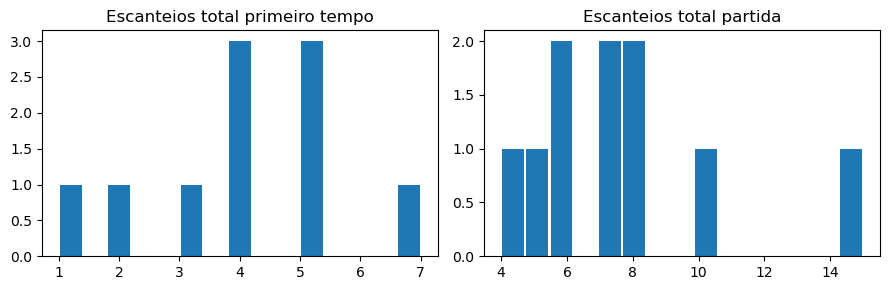

 PRIMEIRO TEMPO: 
1H 85% das partidas - de 5.5 escanteios
1H 85% das partidas + de  1.5 escanteios
1H partidas com menos de 6.5  90 %
1H partidas com menos de 5.5  90 %
1H partidas com menos de 4.5  60 %
1H partidas com mais de 0.5  100 %
1H partidas com mais de 1.5  90 %
1H partidas com mais de 2.5  80 %
JOGO COMPLETO: 
FT 85% das partidas - de  10.5 escanteios
FT 85% das partidas + de  4.5 escanteios
FT partidas com menos de 10.5  90 %
FT partidas com menos de 9.5  80 %
FT partidas com menos de 8.5  80 %
FT partidas com mais de 6.5  60 %
FT partidas com mais de 7.5  40 %
FT partidas com mais de 8.5  20 %
Partidas com saldo de escanteios positivo:  70 %
Partidas com saldo de escanteios negativo:  30 %
Partidas escanteios empatados:  0 %
Média escanteios por partida:  8
desvio padrão:  3


,first_half_corners_for,second_half_corners_for,match_corners_for,first_half_corners_against,second_half_corners_against,match_corners_against,total_match_corners,total_first_half_corners,total_second_half_corners,home_or_away,corners_balance,against
2,4,0,4,0,1,1,5,4,1,Home,3,Millonarios
3,3,2,5,1,2,3,8,4,4,Home,2,Atletico Huila
6,4,4,8,1,6,7,15,5,10,Home,1,Deportivo Cali
10,3,1,4,1,1,2,6,4,2,Home,2,America de Cali
13,0,1,1,2,1,3,4,2,2,Home,-2,Millonarios
15,0,1,1,3,2,5,6,3,3,Home,-4,Alianza Petrolera
18,3,2,5,2,0,2,7,5,2,Home,3,Deportivo Pereira
20,3,1,4,4,2,6,10,7,3,Home,-2,Once Caldas
22,1,4,5,0,2,2,7,1,6,Home,3,Cortulua
24,5,2,7,0,1,1,8,5,3,Home,6,La Equidad


Deportivo Pasto Jogando fora de casa


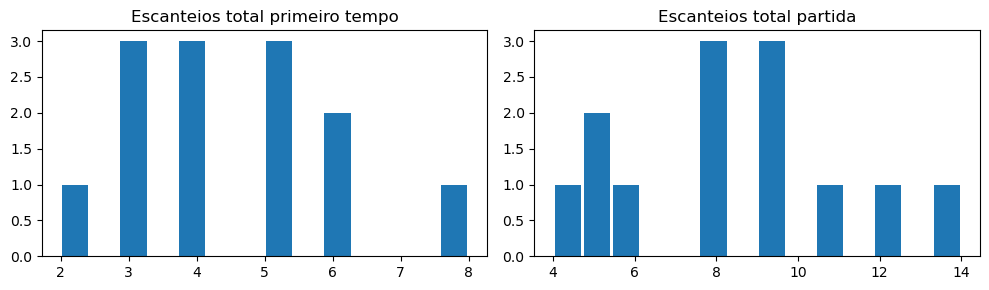

 PRIMEIRO TEMPO: 
1H 85% das partidas - de 6.5 escanteios
1H 85% das partidas + de  2.5 escanteios
1H partidas com menos de 6.5  92 %
1H partidas com menos de 5.5  77 %
1H partidas com menos de 4.5  54 %
1H partidas com mais de 0.5  100 %
1H partidas com mais de 1.5  100 %
1H partidas com mais de 2.5  92 %
JOGO COMPLETO: 
FT 85% das partidas - de  12.5 escanteios
FT 85% das partidas + de  4.5 escanteios
FT partidas com menos de 10.5  77 %
FT partidas com menos de 9.5  77 %
FT partidas com menos de 8.5  54 %
FT partidas com mais de 6.5  69 %
FT partidas com mais de 7.5  69 %
FT partidas com mais de 8.5  46 %
Partidas com saldo de escanteios positivo:  8 %
Partidas com saldo de escanteios negativo:  85 %
Partidas escanteios empatados:  8 %
Média escanteios por partida:  8
desvio padrão:  3


,first_half_corners_for,second_half_corners_for,match_corners_for,first_half_corners_against,second_half_corners_against,match_corners_against,total_match_corners,total_first_half_corners,total_second_half_corners,home_or_away,corners_balance,against
1,2,3,5,3,4,7,12,5,7,Away,-2,Jaguares de Cordoba
2,0,1,1,3,1,4,5,3,2,Away,-3,Millonarios
4,3,0,3,5,1,6,9,8,1,Away,-3,Once Caldas
6,1,1,2,1,1,2,4,2,2,Away,0,Boyaca Chico
8,0,0,0,4,4,8,8,4,4,Away,-8,Independiente Santa Fe
10,0,2,2,6,3,9,11,6,5,Away,-7,FBC Melgar
12,3,2,5,2,2,4,9,5,4,Away,1,Rionegro Aguilas
14,0,1,1,4,0,4,5,4,1,Away,-3,America de Cali
16,2,0,2,1,5,6,8,3,5,Away,-4,Independiente Medellin
18,1,0,1,3,2,5,6,4,2,Away,-4,America de Cali


In [6]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import cloudscraper

def get_corner_stats(team_id:str,is_home:bool):
    scraper = cloudscraper.create_scraper()    
    html = scraper.get(f'https://www.totalcorner.com/team/view/{team_id}').content

    soup = BeautifulSoup(html, 'html.parser')
    while not soup.find("meta", {"name":"description"}):
        print('CAPTCHA')
        time.sleep(10)
        scraper2 = cloudscraper.create_scraper()    
        html = scraper2.get(f'https://www.totalcorner.com/team/view/{team_id}').content
        soup = BeautifulSoup(html, 'html.parser')
    team_name = soup.find("meta", {"name":"description"})["content"]
    team_name = team_name.split(",")[0].replace('Team: ','')
    first_half_corners_for = []
    second_half_corners_for = []
    match_corners_for = []
    first_half_corners_against = []
    second_half_corners_against = []
    match_corners_against = []
    total_match_corners = []
    total_first_half_corners = []
    total_second_half_corners =[]
    home_or_away = []
    corners_balance =[]
    against = []



    table_rows = soup.findAll("tr")
    for rows in table_rows:
        #skip future games
        if rows.find("span", class_="span_half_corner hide"):
            continue
        match = rows.find("td", class_="match_home")
        if match != None:
            home_team = match.find('a').text
        else:
            continue
        match = rows.find("td", class_="match_away")
        if match != None:
            away_team = match.find('a').text
        half_corners = rows.find("span", class_="span_half_corner").text
        match_corners = rows.find("span", class_="span_match_corner").text
        home_half_corners = half_corners.replace('(','').replace(')','').split('-')[0]
        away_half_corners = half_corners.replace('(','').replace(')','').split('-')[1]
        home_match_corners = match_corners.split(' ')[0]
        away_match_corners = match_corners.split(' ')[-1]
        home_second_half_corners = int(home_match_corners) - int(home_half_corners)
        away_second_half_corners = int(away_match_corners) - int(away_half_corners)
        if home_team == team_name:
            against.append(away_team)            
            balance = int(home_match_corners) - int(away_match_corners)
            first_half_corners_for.append(int(home_half_corners))
            second_half_corners_for.append(int(home_second_half_corners))
            match_corners_for.append(int(home_match_corners))
            first_half_corners_against.append(int(away_half_corners))
            second_half_corners_against.append(int(away_second_half_corners))
            match_corners_against.append(int(away_match_corners))
            total_match_corners.append(int(home_match_corners) + int(away_match_corners))
            total_first_half_corners.append(int(home_half_corners) + int(away_half_corners))
            total_second_half_corners.append(int(home_second_half_corners) + int(away_second_half_corners))
            home_or_away.append('Home')
            corners_balance.append(balance)

        else:
            against.append(home_team)  
            balance = int(away_match_corners) - int(home_match_corners)
            first_half_corners_for.append(int(away_half_corners))
            second_half_corners_for.append(int(away_second_half_corners))
            match_corners_for.append(int(away_match_corners))
            first_half_corners_against.append(int(home_half_corners))
            second_half_corners_against.append(int(home_second_half_corners))
            match_corners_against.append(int(home_match_corners))
            total_match_corners.append(int(home_match_corners) + int(away_match_corners))
            total_first_half_corners.append(int(home_half_corners) + int(away_half_corners))
            total_second_half_corners.append(int(home_second_half_corners) + int(away_second_half_corners))
            home_or_away.append('Away')
            corners_balance.append(balance)

    df = pd.DataFrame(list(zip(
            first_half_corners_for,
            second_half_corners_for,
            match_corners_for,
            first_half_corners_against,
            second_half_corners_against,
            match_corners_against,
            total_match_corners,
            total_first_half_corners,
            total_second_half_corners,
            home_or_away,
            corners_balance,
            against
        )),
        columns=[
            'first_half_corners_for',
            'second_half_corners_for',
            'match_corners_for',
            'first_half_corners_against',
            'second_half_corners_against',
            'match_corners_against',
            'total_match_corners',
            'total_first_half_corners',
            'total_second_half_corners',
            'home_or_away',
            'corners_balance',
            'against'

        ])
    if is_home:
        return (team_name, df[(df.home_or_away == "Home")])
    else:
        return (team_name, df[(df.home_or_away == "Away")])



team_id = 931
team2_id = 1005 
home_name, df_home = get_corner_stats(team_id,True)
away_name, df_away = get_corner_stats(team2_id,False)
print(home_name, "Jogando em casa")
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.hist(df_home.total_first_half_corners.tolist(), int(df_home.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total primeiro tempo")
plt.plot()
plt.subplot(1, 2, 2)
plt.hist(df_home.total_match_corners.tolist(), int(df_home.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total partida")
plt.plot()
plt.tight_layout()
plt.show()

print(" PRIMEIRO TEMPO: ")
print('1H 85% das partidas - de', df_home.total_first_half_corners.quantile(0.85,interpolation="higher")+0.5, "escanteios")
print('1H 85% das partidas + de ', df_home.total_first_half_corners.quantile(0.15, interpolation="lower")-0.5, "escanteios")
print('1H partidas com menos de 6.5 ', round((df_home.total_first_half_corners < 7).mean()*100), "%")
print('1H partidas com menos de 5.5 ', round((df_home.total_first_half_corners < 6).mean()*100), "%")
print('1H partidas com menos de 4.5 ', round((df_home.total_first_half_corners < 5).mean()*100), "%")
print('1H partidas com mais de 0.5 ', round((df_home.total_first_half_corners > 0).mean()*100), "%")
print('1H partidas com mais de 1.5 ', round((df_home.total_first_half_corners > 1).mean()*100), "%")
print('1H partidas com mais de 2.5 ', round((df_home.total_first_half_corners > 2).mean()*100), "%")
print("JOGO COMPLETO: ")
print('FT 85% das partidas - de ', df_home.total_match_corners.quantile(0.85,interpolation="higher")+0.5, "escanteios")
print('FT 85% das partidas + de ', df_home.total_match_corners.quantile(0.15,interpolation="lower")-0.5, "escanteios")
print('FT partidas com menos de 10.5 ', round((df_home.total_match_corners < 11).mean()*100), "%")
print('FT partidas com menos de 9.5 ', round((df_home.total_match_corners < 10).mean()*100), "%")
print('FT partidas com menos de 8.5 ', round((df_home.total_match_corners < 9).mean()*100), "%")
print('FT partidas com mais de 6.5 ', round((df_home.total_match_corners > 6).mean()*100), "%")
print('FT partidas com mais de 7.5 ', round((df_home.total_match_corners > 7).mean()*100), "%")
print('FT partidas com mais de 8.5 ', round((df_home.total_match_corners > 8).mean()*100), "%")
print('Partidas com saldo de escanteios positivo: ', round((df_home.corners_balance > 0).mean()*100), "%")
print('Partidas com saldo de escanteios negativo: ', round((df_home.corners_balance < 0).mean()*100), "%")
print('Partidas escanteios empatados: ', round((df_home.corners_balance == 0).mean()*100), "%")
print('Média escanteios por partida: ', round((df_home.total_match_corners).mean()))
print('desvio padrão: ', round((df_home.total_match_corners).std()))
display(df_home)


print(away_name,"Jogando fora de casa")
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(df_away.total_first_half_corners.tolist(), int(df_away.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total primeiro tempo")
plt.plot()
plt.subplot(1, 2, 2)
plt.hist(df_away.total_match_corners.tolist(), int(df_away.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total partida")
plt.plot()
plt.tight_layout()
plt.show()
print(" PRIMEIRO TEMPO: ")
print('1H 85% das partidas - de', df_away.total_first_half_corners.quantile(0.85,interpolation="higher")+.5, "escanteios")
print('1H 85% das partidas + de ', df_away.total_first_half_corners.quantile(0.15, interpolation="lower")-.5, "escanteios")
print('1H partidas com menos de 6.5 ', round((df_away.total_first_half_corners < 7).mean()*100), "%")
print('1H partidas com menos de 5.5 ', round((df_away.total_first_half_corners < 6).mean()*100), "%")
print('1H partidas com menos de 4.5 ', round((df_away.total_first_half_corners < 5).mean()*100), "%")
print('1H partidas com mais de 0.5 ', round((df_away.total_first_half_corners > 0).mean()*100), "%")
print('1H partidas com mais de 1.5 ', round((df_away.total_first_half_corners > 1).mean()*100), "%")
print('1H partidas com mais de 2.5 ', round((df_away.total_first_half_corners > 2).mean()*100), "%")
print("JOGO COMPLETO: ")
print('FT 85% das partidas - de ', df_away.total_match_corners.quantile(0.85,interpolation="higher")+.5, "escanteios")
print('FT 85% das partidas + de ', df_away.total_match_corners.quantile(0.15,interpolation="lower")-.5, "escanteios")
print('FT partidas com menos de 10.5 ', round((df_away.total_match_corners < 11).mean()*100), "%")
print('FT partidas com menos de 9.5 ', round((df_away.total_match_corners < 10).mean()*100), "%")
print('FT partidas com menos de 8.5 ', round((df_away.total_match_corners < 9).mean()*100), "%")
print('FT partidas com mais de 6.5 ', round((df_away.total_match_corners > 6).mean()*100), "%")
print('FT partidas com mais de 7.5 ', round((df_away.total_match_corners > 7).mean()*100), "%")
print('FT partidas com mais de 8.5 ', round((df_away.total_match_corners > 8).mean()*100), "%")
print('Partidas com saldo de escanteios positivo: ', round((df_away.corners_balance > 0).mean()*100), "%")
print('Partidas com saldo de escanteios negativo: ', round((df_away.corners_balance < 0).mean()*100), "%")
print('Partidas escanteios empatados: ', round((df_away.corners_balance == 0).mean()*100), "%")
print('Média escanteios por partida: ', round((df_away.total_match_corners).mean()))
print('desvio padrão: ', round((df_away.total_match_corners).std()))
display(df_away)


In [13]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import matplotlib.pyplot as plt

games_percentage = 0.70
lower_part = (1-games_percentage)/2
higher_part = games_percentage + lower_part
def generate_report():
    desired_leagues = ["France Ligue 1",'Portugal Primeira Liga','Netherlands Eredivisie','	Spain Primera Liga','Spain Segunda','Italy Serie B',
                       'England Championship','England Premier League','Germany Bundesliga I','Italy Serie A','Colombia Primera A','Uruguay Apertura',
                        'Chile Primera Division','Argentina Liga Profesional','USA MLS','Paraguay Division Profesional',
                       'Venezuela Primera Division','Mexico Liga MX','Japan J-League','Germany Bundesliga II']
    html = requests.get('https://www.totalcorner.com/match/today').content
    soup = BeautifulSoup(html, 'html.parser')
    table_rows = soup.findAll("tr")
    for rows in table_rows:
        minutes = rows.find('span', class_="match_status_minutes")
        if not minutes:
            continue
        if minutes.text == "":
            links = rows.findAll('a', href=True)
            league = links[0].text
            if league not in desired_leagues:
                continue
            home_team_id = links[1]['href'].split('/')[-1]
            away_team_id = links[2]['href'].split('/')[-1]
            home_team_name, df_home = get_corner_stats(home_team_id,True)
            away_team_name, df_away = get_corner_stats(away_team_id,False)
            
            home_balance = round((df_home.corners_balance > 0).mean()*100)
            away_balance = round((df_away.corners_balance > 0).mean()*100)
            home_1h_over = df_home.total_first_half_corners.quantile(lower_part, interpolation="lower")-.5
            home_1h_under = df_home.total_first_half_corners.quantile(higher_part,interpolation="higher")+0.5
            away_1h_over = df_away.total_first_half_corners.quantile(lower_part, interpolation="lower")-.5
            away_1h_under = df_away.total_first_half_corners.quantile(higher_part,interpolation="higher")+0.5
            home_ft_over = df_home.total_match_corners.quantile(lower_part, interpolation="lower")-.5
            home_ft_under = df_home.total_match_corners.quantile(higher_part,interpolation="higher")+0.5
            away_ft_over = df_away.total_match_corners.quantile(lower_part, interpolation="lower")-.5
            away_ft_under = df_away.total_match_corners.quantile(higher_part,interpolation="higher")+0.5
            print(f'{home_team_name} X {away_team_name}')
            print('1H OVER:', min(home_1h_over,away_1h_over),"1H UNDER:",max(home_1h_under,away_1h_under))
            print('FT OVER:', min(home_ft_over,away_ft_over),"FT UNDER:",max(home_ft_under,away_ft_under))
            balance_dif = home_balance - away_balance 
            if abs(balance_dif) >= 40:
                print(f'POTENCIAL TIME COM MAIS ESCANTEIOS: {home_team_name}#{home_team_id} = {home_balance}  | {away_team_name}#{away_team_id} = {away_balance}', )


generate_report()

Guarani Asuncion X General Caballero JLM
1H OVER: 1.5 1H UNDER: 7.5
FT OVER: 5.5 FT UNDER: 12.5
Deportes Tolima X Deportivo Pasto
1H OVER: 1.5 1H UNDER: 6.5
FT OVER: 4.5 FT UNDER: 12.5
POTENCIAL TIME COM MAIS ESCANTEIOS: Deportes Tolima#931 = 70  | Deportivo Pasto#1005 = 8
